In [2]:
import numpy as np
import warnings
import pandas as pd
from calibrators import * 
import pickle
warnings.filterwarnings("ignore")
import torch
import sys
from utils import *
sys.path.append('../')
import time
import copy
from SLURM.sklearn_config import *

# calculating ECEs on everything

In [2]:
def calc_ece(y_pred_val,y_val,y_pred_test, y_test , method_name,dataset_name,model_name,shuffle,new_stab_dir):
    S_val=np.load(new_stab_dir+f'stab_{method_name}_{dataset_name}_{model_name}_{shuffle}.npy')
    S_test=np.load(new_stab_dir+f'test_stab_{method_name}_{dataset_name}_{model_name}_{shuffle}.npy')
    stabCal = StabilityCalibrator()
    stabCal.fit(S_val ,y_pred_val==y_val)
    return stabCal.ECE(S_test, y_pred_test, y_test)
    
            

In [6]:
Series = []
datasets = ['Fashion','MNIST','SignLanguage']#,'CIFAR_RGB','GTSRB_RGB']
models = ['RF','GB','pytorch']
for dataset_name in datasets:
    for model_name in models:
        ECEs = []
        for shuffle in range(10):
            print(f'calculating {dataset_name}-{model_name}-{shuffle} ece....')
            ece = {}
            PATH_model= f'./stab/{dataset_name}/stab_2pool_{dataset_name}_{model_name}_{shuffle}.npy'
            
            # if not os.path.exists(PATH_model):
            #     continue
            #load model
            
            #model_info= load_model(dataset_name, model_name, shuffle)
            model_info= load_shuffle(dataset_name, model_name, shuffle)
            data=copy.copy(model_info.data)
            if model_name!='pytorch':
                model_dir =  f'{dataset_name}/{shuffle}/model/model_{dataset_name}_{model_name}.sav'
                model = pickle.load(open(model_dir, 'rb'))
            
            # compute ece's
            #Base
            idCal = IdentityCalibrator()
            idCal.fit(model_info.all_predictions_val ,model_info.y_pred_val==model_info.data.y_val)
            ece['Base'] = idCal.ECE(model_info.all_predictions_test, model_info.y_pred_test, model_info.data.y_test)
            if model_name=='pytorch':
                ece['SKlearn_calibrator_isotonic']=100
                ece['SKlearn_calibrator_platt']=100
            else:
                #Isotonic_sklearn
                ece['SKlearn_calibrator_isotonic'] = SKlearn_calibrator(data,'isotonic',model).fit().ECE()

            # #iso_self_imp
            # isoCal = IsotonicCalibrator()
            # isoCal.fit(model_info.all_predictions_val ,model_info.y_pred_val==model_info.data.y_val)
            # ece['IsotonicCalibrator'] = isoCal.ECE(model_info.all_predictions_test, model_info.y_pred_test, model_info.data.y_test)

                #sklearn platt
                ece['SKlearn_calibrator_platt'] = SKlearn_calibrator(data,'sigmoid',model).fit().ECE()

#             #plat_self_imp
#             platCal = PlattCalibrator()
#             platCal.fit(model_info.all_predictions_val ,model_info.y_pred_val==model_info.data.y_val)
#             ece['PlattCalibrator'] = platCal.ECE(model_info.all_predictions_test, model_info.y_pred_test, model_info.data.y_test)

  #stab
            stabCal = StabilityCalibrator()
            stabCal.fit(model_info.stability_val ,model_info.y_pred_val==model_info.data.y_val)
            ece['StabilityCalibrator'] = stabCal.ECE(model_info.stability_test, model_info.y_pred_test, model_info.data.y_test)

            # #Sep
            # sepCal = SeparationCalibrator()
            # sepCal.fit(model_info.sep_val ,model_info.y_pred_val==model_info.data.y_val)
            # ece['SeparationCalibrator'] = sepCal.ECE(model_info.sep_test, model_info.y_pred_test, model_info.data.y_test)
            
                      
            new_stab_dir= f'./stab/{dataset_name}/'
            
            for method in ['pool','maxpool','resize','PCA','rand_pix','rand_set','kmeans']:
                for red_param in [2,3,4]:
                    if method in ['pool','maxpool']:
                        method_name=f'{red_param}{method}'
                    else:
                        method_name=f'{method}_{red_param}'
                    ece[method_name]= calc_ece(model_info.y_pred_val,model_info.data.y_val,model_info.y_pred_test, model_info.data.y_test , method_name,dataset_name,model_name,shuffle,new_stab_dir)
#            

            # HB_toplabel
            HBcali = HBCalibrator()
            HBcali.fit(model_info.all_predictions_val, model_info.data.y_val + 1)
            prob_HB = HBcali.calibrate(model_info.all_predictions_test)
            ece['HBCalibrator'] = ECE_calc(prob_HB, model_info.y_pred_test, model_info.data.y_test, bins=15)

            #SBC
            SBCcali = SBCCalibrator()
            SBCcali.fit(model_info.all_predictions_val, model_info.data.y_val)
            SBC_probs_test = SBCcali.calibrate(model_info.all_predictions_test)
            y_SBC_test = np.argmax(SBC_probs_test,axis=1)
            ece['SBCCalibrator'] = ECE_calc(SBC_probs_test, y_SBC_test, model_info.data.y_test, bins=15)

            PATH = f'./{dataset_name}/{shuffle}/{model_name}/ece.npy'
            # np.save(PATH,ece)
            
            print(ece)
            ECEs.append(ece)
            
    
        values = np.array([list(dic.values()) for dic in ECEs]) 
        conf_interval = np.apply_along_axis(mean_confidence_interval_str, 0, values)
        calib_methods = list(ece.keys())
        prep_df_mnist = {calib:val for val, calib in zip(conf_interval, calib_methods)}
        series = pd.DataFrame.from_dict(prep_df_mnist, orient = 'index', columns=[f'{dataset_name}-{model_name}'])
        Series.append(series.T)

calculating Fashion-RF-0 ece....
{'Base': 0.09382536167717813, 'SKlearn_calibrator_isotonic': 0.006870713460098766, 'SKlearn_calibrator_platt': 0.038249203663793876, 'StabilityCalibrator': 0.004581974991100572, '2pool': 0.007115958805134333, '3pool': 0.008440976165221645, '4pool': 0.009230976237841375, '2maxpool': 0.008087211496259817, '3maxpool': 0.00566216934291164, '4maxpool': 0.010012484109443475, 'resize_2': 0.007117809291030321, 'resize_3': 0.013513331719099013, 'resize_4': 0.008644452590648947, 'PCA_2': 0.0077603816781398344, 'PCA_3': 0.008404360201181477, 'PCA_4': 0.007675507144811708, 'rand_pix_2': 0.01535965626636111, 'rand_pix_3': 0.01657111445540061, 'rand_pix_4': 0.015528673784894781, 'rand_set_2': 0.008485785940987244, 'rand_set_3': 0.006706784687583685, 'rand_set_4': 0.007491565155411305, 'kmeans_2': 0.007763202939474232, 'kmeans_3': 0.0069947247823955745, 'kmeans_4': 0.00772703002851604, 'HBCalibrator': 0.011279481761960556, 'SBCCalibrator': 0.033675990041226476}
calcul

In [7]:
df_comparison = pd.concat(Series)[:]
df_comparison.style.apply(color_max, axis=1)

,Base,SKlearn_calibrator_isotonic,SKlearn_calibrator_platt,StabilityCalibrator,2pool,3pool,4pool,2maxpool,3maxpool,4maxpool,resize_2,resize_3,resize_4,PCA_2,PCA_3,PCA_4,rand_pix_2,rand_pix_3,rand_pix_4,rand_set_2,rand_set_3,rand_set_4,kmeans_2,kmeans_3,kmeans_4,HBCalibrator,SBCCalibrator
Fashion-RF,0.0918+-0.0014,0.0091+-0.0011,0.0374+-0.0012,0.0074+-0.0016,0.0081+-0.0016,0.0078+-0.0010,0.0082+-0.0014,0.0087+-0.0014,0.0083+-0.0016,0.0072+-0.0013,0.0081+-0.0016,0.0082+-0.0019,0.0081+-0.0011,0.0079+-0.0012,0.0072+-0.0008,0.0082+-0.0020,0.0125+-0.0024,0.0179+-0.0029,0.0188+-0.0024,0.0075+-0.0012,0.0073+-0.0009,0.0086+-0.0015,0.0087+-0.0008,0.0086+-0.0017,0.0076+-0.0008,0.0108+-0.0016,0.0345+-0.0031
Fashion-GB,0.0245+-0.0023,0.0380+-0.0020,0.0571+-0.0391,0.0073+-0.0013,0.0078+-0.0009,0.0077+-0.0020,0.0078+-0.0014,0.0077+-0.0015,0.0081+-0.0013,0.0074+-0.0017,0.0078+-0.0009,0.0078+-0.0016,0.0078+-0.0012,0.0082+-0.0009,0.0084+-0.0011,0.0082+-0.0011,0.0139+-0.0023,0.0157+-0.0031,0.0176+-0.0036,0.0077+-0.0008,0.0072+-0.0017,0.0072+-0.0013,0.0069+-0.0014,0.0074+-0.0010,0.0082+-0.0017,0.0106+-0.0015,0.0390+-0.0046
Fashion-pytorch,0.0786+-0.0027,100.0000+-0.00,100.0000+-0.00,0.0080+-0.0015,0.0063+-0.0012,0.0070+-0.0012,0.0071+-0.0009,0.0061+-0.0008,0.0066+-0.0007,0.0069+-0.0010,0.0063+-0.0012,0.0071+-0.0009,0.0076+-0.0017,0.0076+-0.0015,0.0068+-0.0014,0.0077+-0.0011,0.0110+-0.0018,0.0131+-0.0018,0.0149+-0.0033,0.0075+-0.0014,0.0064+-0.0013,0.0073+-0.0012,0.0068+-0.0011,0.0068+-0.0017,0.0062+-0.0015,0.0101+-0.0018,0.0724+-0.0046
MNIST-RF,0.1629+-0.0016,0.0090+-0.0012,0.0148+-0.0007,0.0039+-0.0006,0.0040+-0.0008,0.0036+-0.0007,0.0047+-0.0007,0.0032+-0.0005,0.0042+-0.0006,0.0038+-0.0008,0.0040+-0.0008,0.0038+-0.0005,0.0048+-0.0011,0.0033+-0.0007,0.0037+-0.0008,0.0034+-0.0004,0.0036+-0.0011,0.0036+-0.0012,0.0036+-0.0015,0.0042+-0.0010,0.0036+-0.0006,0.0042+-0.0009,0.0041+-0.0005,0.0035+-0.0006,0.0037+-0.0006,0.0053+-0.0004,0.0366+-0.0038
MNIST-GB,0.0170+-0.0010,0.0174+-0.0015,0.0194+-0.0013,0.0036+-0.0007,0.0038+-0.0010,0.0035+-0.0007,0.0036+-0.0009,0.0030+-0.0007,0.0034+-0.0010,0.0032+-0.0009,0.0035+-0.0007,0.0034+-0.0008,0.0037+-0.0011,0.0036+-0.0008,0.0037+-0.0009,0.0032+-0.0006,0.0030+-0.0012,0.0038+-0.0012,0.0030+-0.0013,0.0040+-0.0005,0.0038+-0.0009,0.0038+-0.0008,0.0035+-0.0004,0.0029+-0.0006,0.0037+-0.0007,0.0048+-0.0008,0.0823+-0.0024
MNIST-pytorch,0.0065+-0.0006,100.0000+-0.00,100.0000+-0.00,0.0016+-0.0006,0.0019+-0.0004,0.0022+-0.0006,0.0018+-0.0004,0.0018+-0.0004,0.0020+-0.0004,0.0016+-0.0005,0.0019+-0.0005,0.0017+-0.0005,0.0017+-0.0004,0.0021+-0.0004,0.0018+-0.0003,0.0017+-0.0004,0.0015+-0.0005,0.0014+-0.0006,0.0016+-0.0007,0.0020+-0.0004,0.0018+-0.0005,0.0018+-0.0005,0.0015+-0.0004,0.0018+-0.0005,0.0018+-0.0005,0.0027+-0.0010,0.0870+-0.0052
SignLanguage-RF,0.2536+-0.0015,0.0039+-0.0006,0.0174+-0.0008,0.0008+-0.0002,0.0012+-0.0002,0.0015+-0.0004,0.0019+-0.0003,0.0012+-0.0003,0.0017+-0.0005,0.0014+-0.0004,0.0012+-0.0002,0.0012+-0.0003,0.0016+-0.0003,0.0009+-0.0002,0.0012+-0.0003,0.0014+-0.0004,0.0016+-0.0005,0.0020+-0.0006,0.0020+-0.0006,0.0018+-0.0004,0.0017+-0.0003,0.0014+-0.0004,0.0013+-0.0004,0.0019+-0.0004,0.0012+-0.0004,0.0019+-0.0006,0.1688+-0.0066
SignLanguage-GB,0.0059+-0.0010,0.0405+-0.0018,0.0596+-0.0017,0.0008+-0.0003,0.0012+-0.0002,0.0018+-0.0004,0.0024+-0.0003,0.0014+-0.0003,0.0024+-0.0003,0.0027+-0.0004,0.0012+-0.0002,0.0013+-0.0003,0.0019+-0.0004,0.0009+-0.0003,0.0009+-0.0003,0.0014+-0.0003,0.0026+-0.0006,0.0027+-0.0005,0.0031+-0.0004,0.0023+-0.0004,0.0031+-0.0005,0.0035+-0.0006,0.0012+-0.0002,0.0032+-0.0005,0.0034+-0.0008,0.0047+-0.0005,0.3097+-0.0017
SignLanguage-pytorch,0.0025+-0.0008,100.0000+-0.00,100.0000+-0.00,0.0004+-0.0003,0.0003+-0.0001,0.0004+-0.0001,0.0006+-0.0002,0.0003+-0.0001,0.0005+-0.0002,0.0006+-0.0001,0.0003+-0.0001,0.0003+-0.0001,0.0004+-0.0001,0.0001+-0.0001,0.0003+-0.0001,0.0004+-0.0001,0.0006+-0.0002,0.0008+-0.0003,0.0009+-0.0003,0.0005+-0.0002,0.0006+-0.0002,0.0006+-0.0002,0.0002+-0.0001,0.0

In [8]:
df_comparison.to_csv("all_eces.csv")

In [34]:
np.array(df_comparison.columns)

array(['Base', 'SKlearn_calibrator_isotonic', 'SKlearn_calibrator_platt',
       'StabilityCalibrator', '2pool', '3pool', '4pool', '2maxpool',
       '3maxpool', '4maxpool', 'resize_2', 'resize_3', 'resize_4',
       'PCA_2', 'PCA_3', 'PCA_4', 'rand_pix_2', 'rand_pix_3',
       'rand_pix_4', 'rand_set_2', 'rand_set_3', 'rand_set_4', 'kmeans_2',
       'kmeans_3', 'kmeans_4', 'HBCalibrator', 'SBCCalibrator'],
      dtype=object)

In [37]:
df_comparison.iloc[0].index

Index(['Base', 'SKlearn_calibrator_isotonic', 'SKlearn_calibrator_platt',
       'StabilityCalibrator', '2pool', '3pool', '4pool', '2maxpool',
       '3maxpool', '4maxpool', 'resize_2', 'resize_3', 'resize_4', 'PCA_2',
       'PCA_3', 'PCA_4', 'rand_pix_2', 'rand_pix_3', 'rand_pix_4',
       'rand_set_2', 'rand_set_3', 'rand_set_4', 'kmeans_2', 'kmeans_3',
       'kmeans_4', 'HBCalibrator', 'SBCCalibrator'],
      dtype='object')

In [48]:
row = df_comparison.iloc[0]
y=np.array([ row.loc[i].split('+-') for i in list(row.index.values)])
y= y[:,0]
y=[float(i) for i in y]
y

[0.0918,
 0.0091,
 0.0374,
 0.0074,
 0.0081,
 0.0078,
 0.0082,
 0.0087,
 0.0083,
 0.0072,
 0.0081,
 0.0082,
 0.0081,
 0.0079,
 0.0072,
 0.0082,
 0.0125,
 0.0179,
 0.0188,
 0.0075,
 0.0073,
 0.0086,
 0.0087,
 0.0086,
 0.0076,
 0.0108,
 0.0345]

In [57]:
def create_scatter(dataset,model):    
    fig = plt.figure(figsize=(15,10), dpi=80)
    row = df_comparison.loc[f'{dataset}-{model}']
    x = list(row.index.values)
    div_y=np.array([ row.loc[i].split('+-') for i in list(row.index.values)])
    y= div_y[:,0]
    yerr=div_y[:,1]
    y=[float(i) for i in y]

    yerr= [float(i) for i in yerr]
    plt.errorbar(x[1:], y[1:], yerr=yerr[1:], label='both limits (default)',fmt="o")


    plt.xticks(rotation=45, ha='right')
    plt.plot(x[1:],[y[0]]*(len(x)-1))
    plt.title(f'{dataset}-{model}- ECE comparison')
    plt.show()

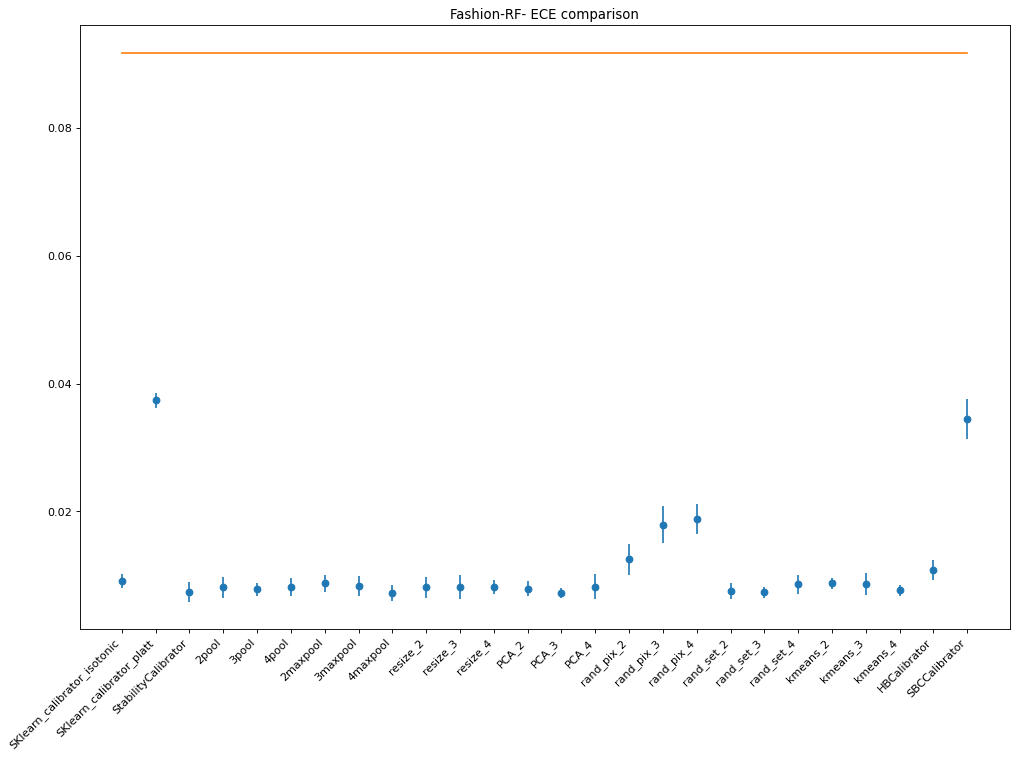

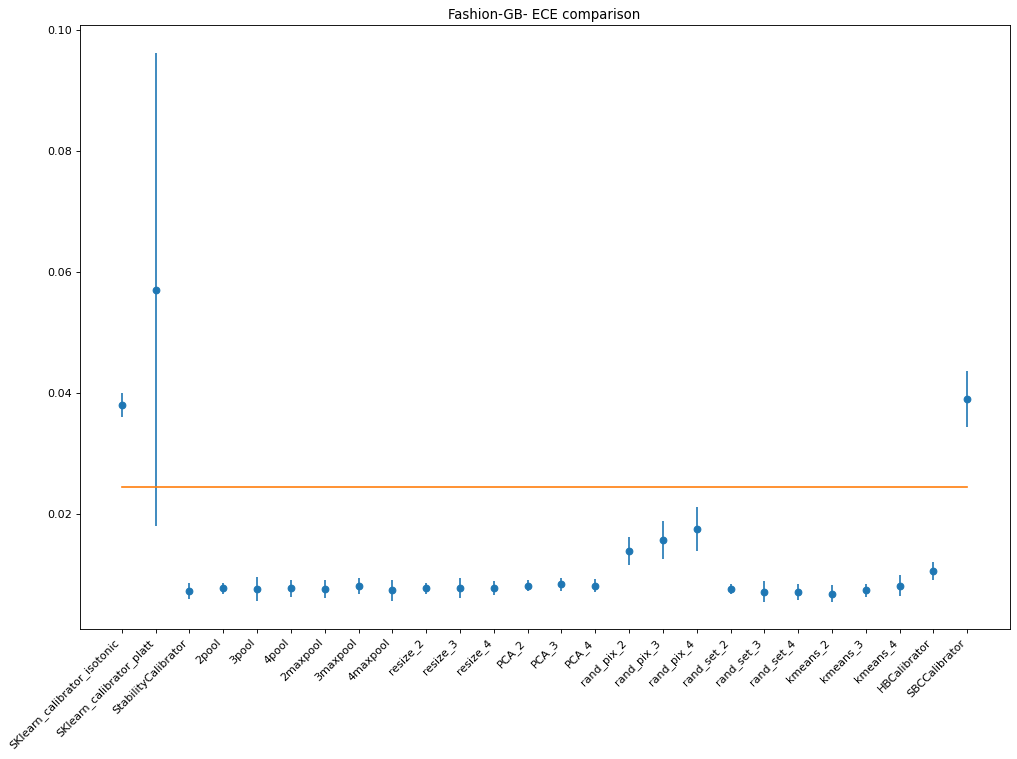

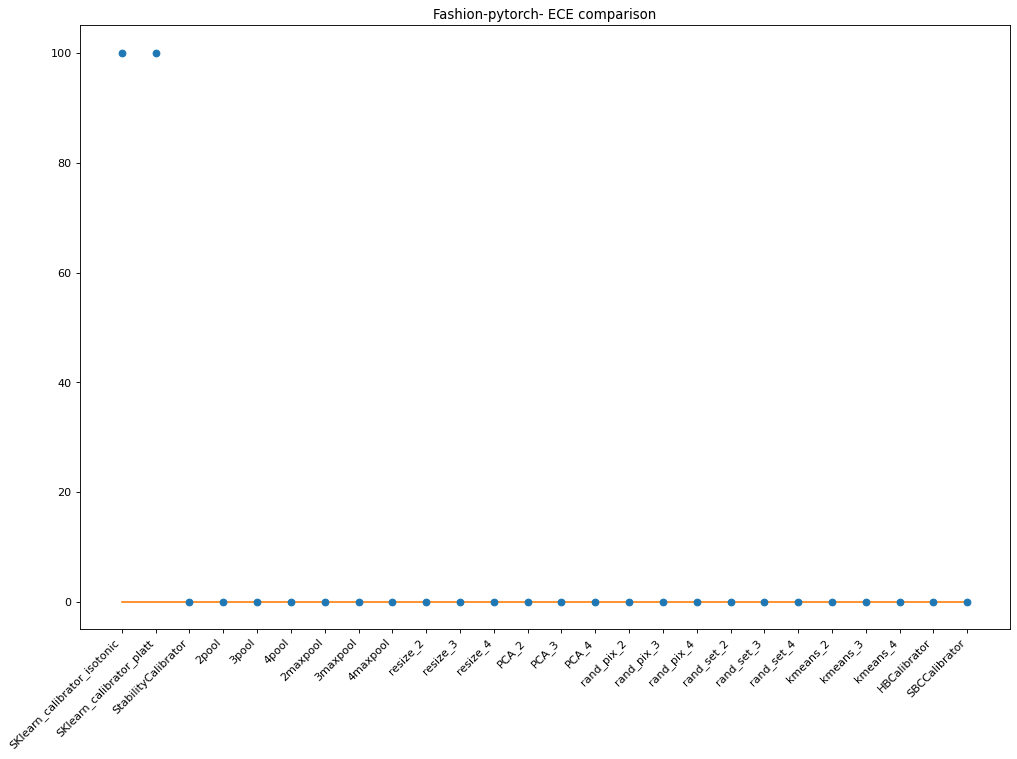

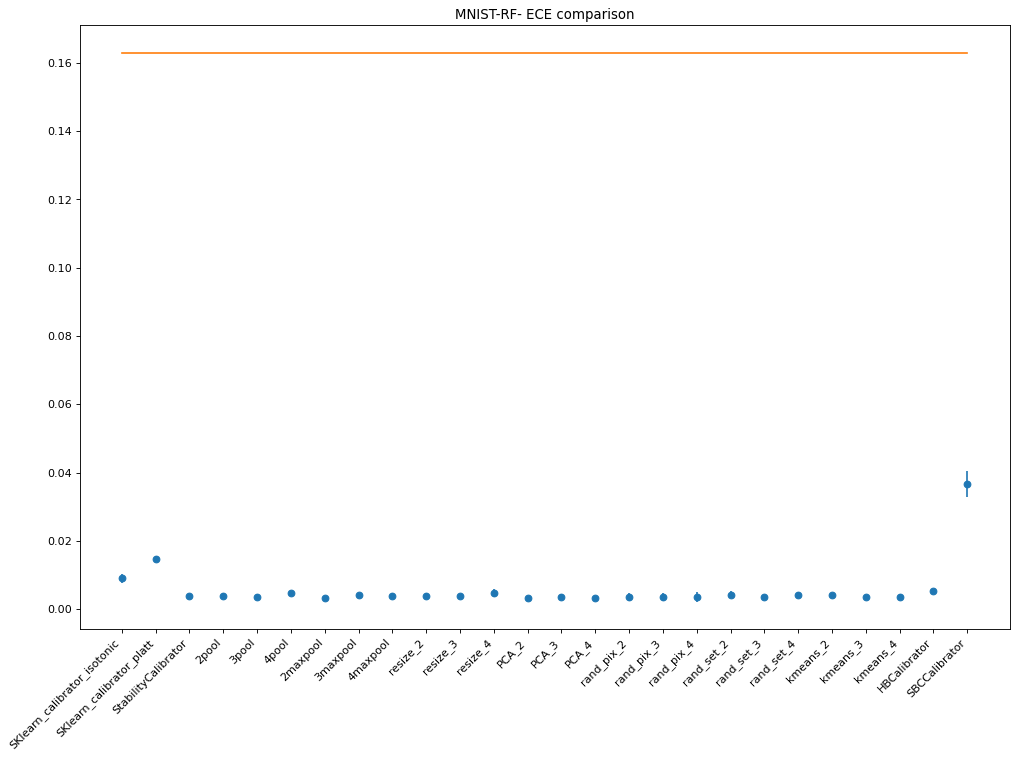

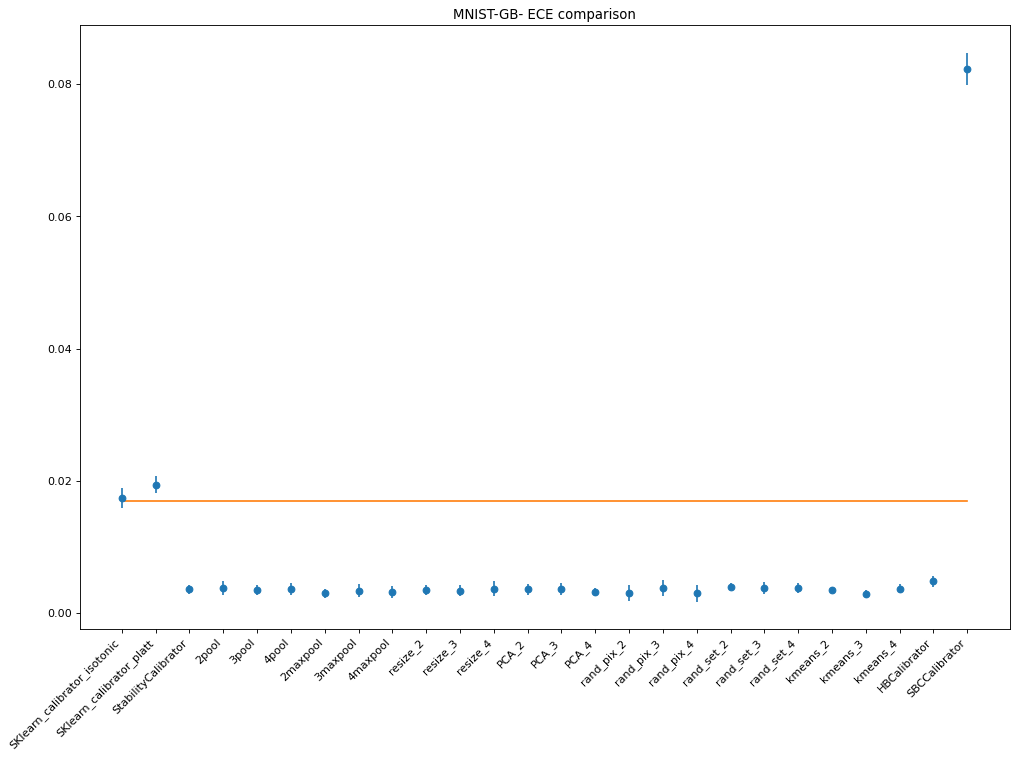

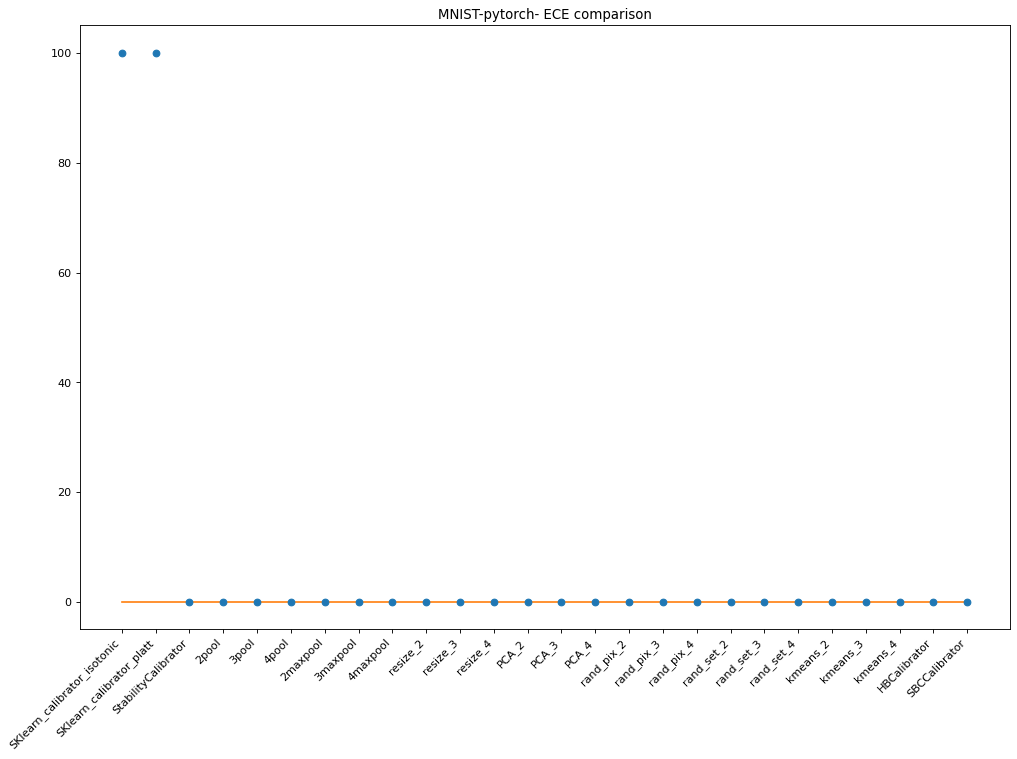

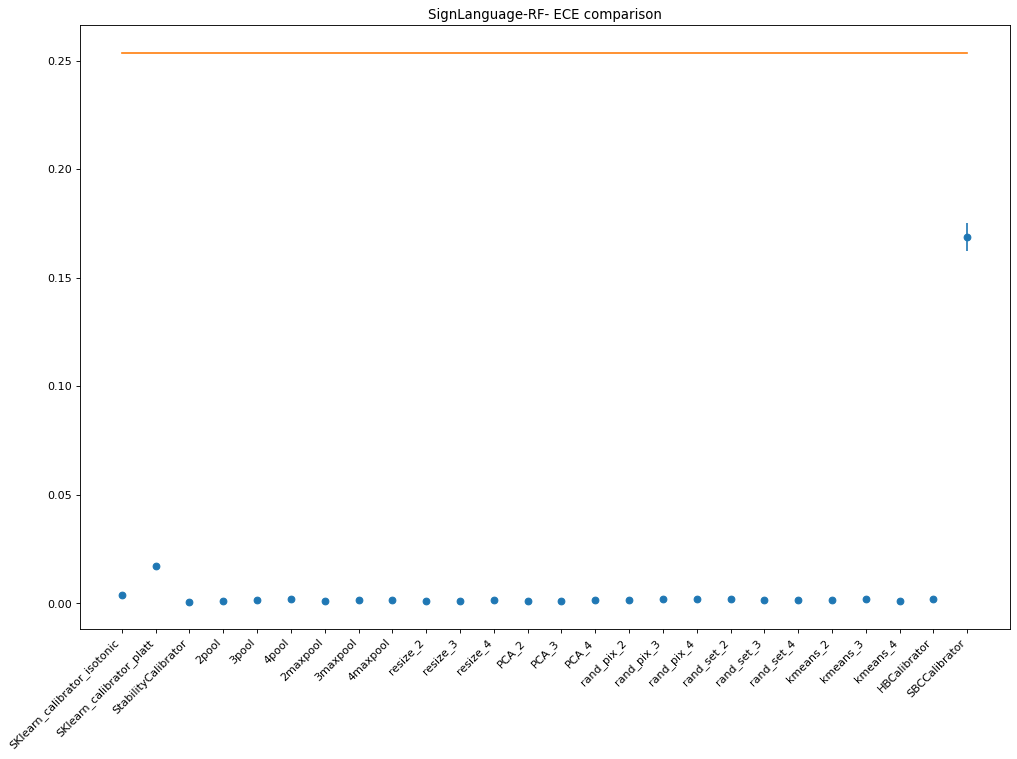

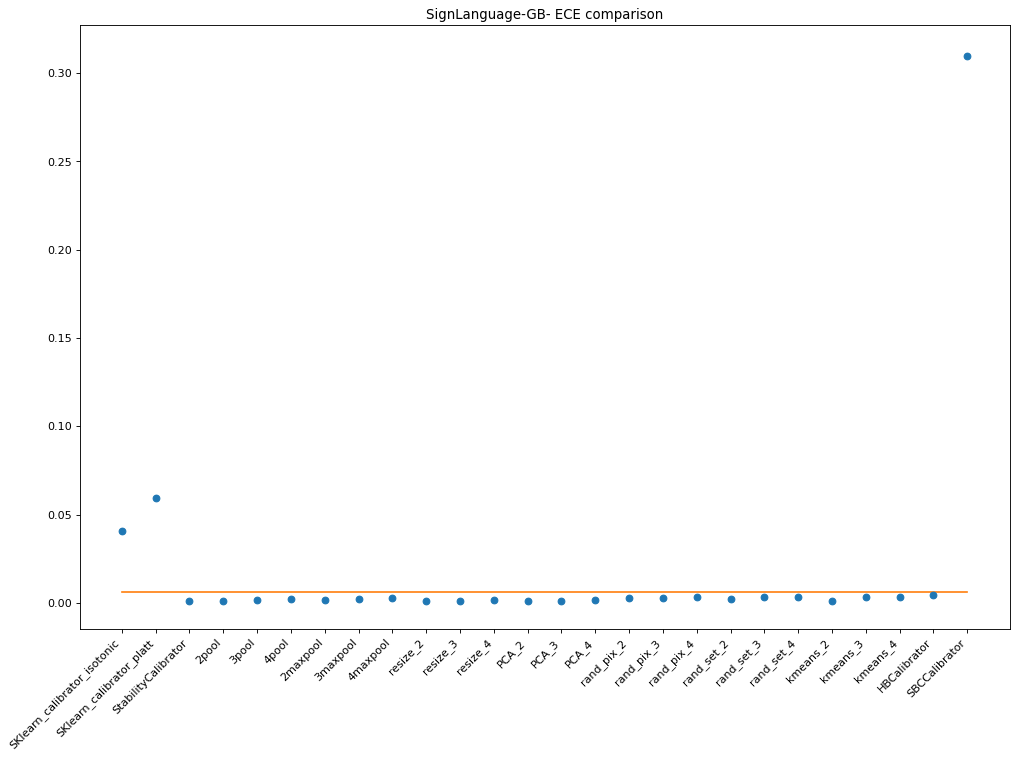

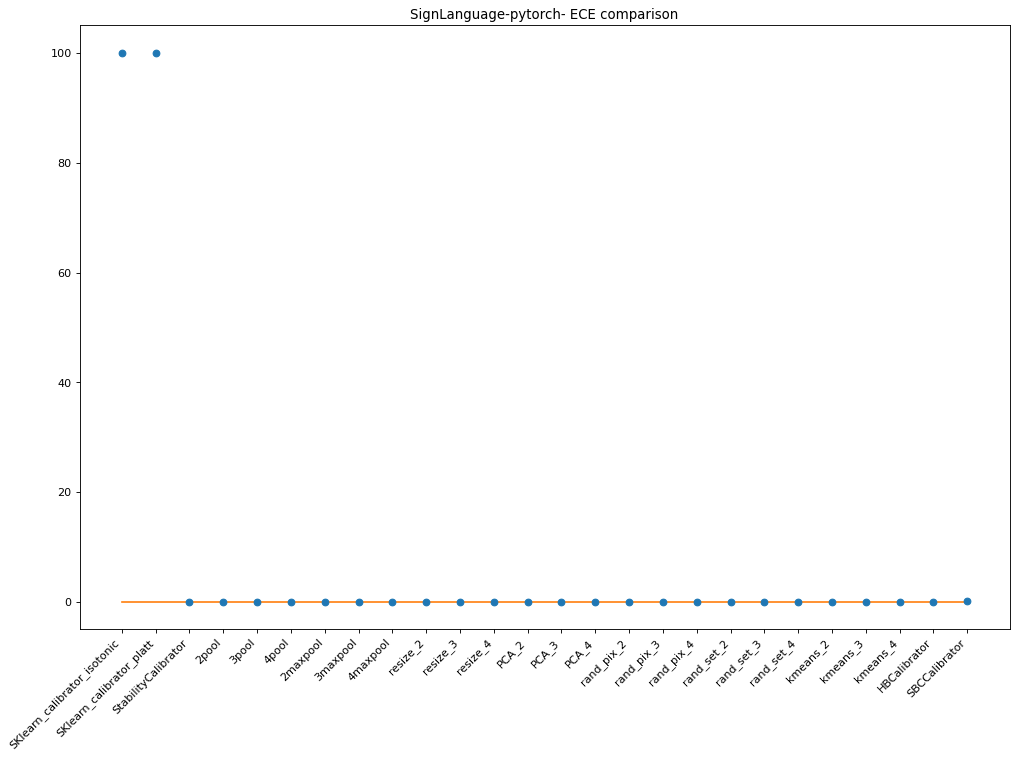

In [59]:
datasets = ['Fashion','MNIST','SignLanguage']#,'CIFAR_RGB','GTSRB_RGB']
models = ['RF','GB','pytorch']
for dataset_name in datasets:
    for model_name in models:
        create_scatter(dataset_name,model_name)

In [3]:
Series = []
datasets = ['MNIST','Fashion','SignLanguage','CIFAR_RGB','GTSRB_RGB']
models = ['RF','GB','pytorch']
for dataset_name in datasets:
    for model_name in models:
        ECEs = []
        for shuffle in range(10):
            print(f'calculating {dataset_name}-{model_name}-{shuffle} ece....')
            ece = {}
            PATH_model= f'./stab/{dataset_name}/stab_2pool_{dataset_name}_{model_name}_{shuffle}.npy'
            
            # if not os.path.exists(PATH_model):
            #     continue
            #load model
            
            #model_info= load_model(dataset_name, model_name, shuffle)
            model_info= load_shuffle(dataset_name, model_name, shuffle)
            data=copy.copy(model_info.data)
            if model_name!='pytorch':
                model_dir =  f'{dataset_name}/{shuffle}/model/model_{dataset_name}_{model_name}.sav'
                model = pickle.load(open(model_dir, 'rb'))
            
            # compute ece's
            #Base
            idCal = IdentityCalibrator()
            idCal.fit(model_info.all_predictions_val ,model_info.y_pred_val==model_info.data.y_val)
            ece['Base'] = idCal.ECE(model_info.all_predictions_test, model_info.y_pred_test, model_info.data.y_test)
            if model_name=='pytorch':
                ece['SKlearn_calibrator_isotonic']=100
                ece['SKlearn_calibrator_platt']=100
            else:
                #Isotonic_sklearn
                ece['SKlearn_calibrator_isotonic'] = SKlearn_calibrator(data,'isotonic',model).fit().ECE()

            # #iso_self_imp
            # isoCal = IsotonicCalibrator()
            # isoCal.fit(model_info.all_predictions_val ,model_info.y_pred_val==model_info.data.y_val)
            # ece['IsotonicCalibrator'] = isoCal.ECE(model_info.all_predictions_test, model_info.y_pred_test, model_info.data.y_test)

                #sklearn platt
                ece['SKlearn_calibrator_platt'] = SKlearn_calibrator(data,'sigmoid',model).fit().ECE()

#             #plat_self_imp
#             platCal = PlattCalibrator()
#             platCal.fit(model_info.all_predictions_val ,model_info.y_pred_val==model_info.data.y_val)
#             ece['PlattCalibrator'] = platCal.ECE(model_info.all_predictions_test, model_info.y_pred_test, model_info.data.y_test)
 
#             #stab
            stabCal = StabilityCalibrator()
            stabCal.fit(model_info.stability_val ,model_info.y_pred_val==model_info.data.y_val)
            ece['StabilityCalibrator'] = stabCal.ECE(model_info.stability_test, model_info.y_pred_test, model_info.data.y_test)

            # #Sep
            # sepCal = SeparationCalibrator()
            # sepCal.fit(model_info.sep_val ,model_info.y_pred_val==model_info.data.y_val)
            # ece['SeparationCalibrator'] = sepCal.ECE(model_info.sep_test, model_info.y_pred_test, model_info.data.y_test)
            
            new_stab_dir= f'./stab/{dataset_name}/'
        
            #stab avg2
            stab2avg_val=np.load(new_stab_dir+f'stab_2pool_{dataset_name}_{model_name}_{shuffle}.npy')
            stab2avg_test=np.load(new_stab_dir+f'test_stab_2pool_{dataset_name}_{model_name}_{shuffle}.npy')
            stab2avgCal = StabilityCalibrator()
            stab2avgCal.fit(stab2avg_val ,model_info.y_pred_val==model_info.data.y_val)
            ece['Stab2avg'] = stab2avgCal.ECE(stab2avg_test, model_info.y_pred_test, model_info.data.y_test)

            
            #stab avg3
            stab3avg_val=np.load(new_stab_dir+f'stab_3pool_{dataset_name}_{model_name}_{shuffle}.npy')
            stab3avg_test=np.load(new_stab_dir+f'test_stab_3pool_{dataset_name}_{model_name}_{shuffle}.npy')
            stab3avgCal = StabilityCalibrator()
            stab3avgCal.fit(stab3avg_val ,model_info.y_pred_val==model_info.data.y_val)
            ece['Stab3avg'] = stab3avgCal.ECE(stab3avg_test, model_info.y_pred_test, model_info.data.y_test)

            
            #stab avg4
            stab4avg_val=np.load(new_stab_dir+f'stab_4pool_{dataset_name}_{model_name}_{shuffle}.npy')
            stab4avg_test=np.load(new_stab_dir+f'test_stab_4pool_{dataset_name}_{model_name}_{shuffle}.npy')
            stab4avgCal = StabilityCalibrator()
            stab4avgCal.fit(stab4avg_val ,model_info.y_pred_val==model_info.data.y_val)
            ece['Stab4avg'] = stab4avgCal.ECE(stab4avg_test, model_info.y_pred_test, model_info.data.y_test)
            
            
            #stab max2
            stab2max_val=np.load(new_stab_dir+f'stab_2maxpool_{dataset_name}_{model_name}_{shuffle}.npy')
            stab2max_test=np.load(new_stab_dir+f'test_stab_2maxpool_{dataset_name}_{model_name}_{shuffle}.npy')
            stab2maxCal = StabilityCalibrator()
            stab2maxCal.fit(stab2max_val ,model_info.y_pred_val==model_info.data.y_val)
            ece['Stab2max'] = stab2maxCal.ECE(stab2max_test, model_info.y_pred_test, model_info.data.y_test)
            
            #stab max3
            stab3max_val=np.load(new_stab_dir+f'stab_3maxpool_{dataset_name}_{model_name}_{shuffle}.npy')
            stab3max_test=np.load(new_stab_dir+f'test_stab_3maxpool_{dataset_name}_{model_name}_{shuffle}.npy')
            stab3maxCal = StabilityCalibrator()
            stab3maxCal.fit(stab3max_val ,model_info.y_pred_val==model_info.data.y_val)
            ece['Stab3max'] = stab3maxCal.ECE(stab3max_test, model_info.y_pred_test, model_info.data.y_test)
            

            #stab max4
            stab4max_val=np.load(new_stab_dir+f'stab_4maxpool_{dataset_name}_{model_name}_{shuffle}.npy')
            stab4max_test=np.load(new_stab_dir+f'test_stab_4maxpool_{dataset_name}_{model_name}_{shuffle}.npy')
            stab4maxCal = StabilityCalibrator()
            stab4maxCal.fit(stab4max_val ,model_info.y_pred_val==model_info.data.y_val)
            ece['Stab4max'] = stab4maxCal.ECE(stab4max_test, model_info.y_pred_test, model_info.data.y_test)
            
            

            # HB_toplabel
            HBcali = HBCalibrator()
            HBcali.fit(model_info.all_predictions_val, model_info.data.y_val + 1)
            prob_HB = HBcali.calibrate(model_info.all_predictions_test)
            ece['HBCalibrator'] = ECE_calc(prob_HB, model_info.y_pred_test, model_info.data.y_test, bins=15)

            #SBC
            SBCcali = SBCCalibrator()
            SBCcali.fit(model_info.all_predictions_val, model_info.data.y_val)
            SBC_probs_test = SBCcali.calibrate(model_info.all_predictions_test)
            y_SBC_test = np.argmax(SBC_probs_test,axis=1)
            ece['SBCCalibrator'] = ECE_calc(SBC_probs_test, y_SBC_test, model_info.data.y_test, bins=15)

            PATH = f'./{dataset_name}/{shuffle}/{model_name}/ece.npy'
            # np.save(PATH,ece)
            
            print(ece)
            ECEs.append(ece)
            
    
        values = np.array([list(dic.values()) for dic in ECEs]) 
        conf_interval = np.apply_along_axis(mean_confidence_interval_str, 0, values)
        calib_methods = list(ece.keys())
        prep_df_mnist = {calib:val for val, calib in zip(conf_interval, calib_methods)}
        series = pd.DataFrame.from_dict(prep_df_mnist, orient = 'index', columns=[f'{dataset_name}-{model_name}'])
        Series.append(series.T)

calculating MNIST-RF-0 ece....
{'Base': 0.1658024551817865, 'SKlearn_calibrator_isotonic': 0.007236461293702406, 'SKlearn_calibrator_platt': 0.013389381446227292, 'StabilityCalibrator': 0.003758624189585668, 'Stab2avg': 0.004687860467464543, 'Stab3avg': 0.0034928307962898194, 'Stab4avg': 0.0042824515882548455, 'Stab2max': 0.0036200852331773887, 'Stab3max': 0.004857055470016411, 'Stab4max': 0.005279742034634669, 'HBCalibrator': 0.004941807756706013, 'SBCCalibrator': 0.03498153236265749}
calculating MNIST-RF-1 ece....
{'Base': 0.16442418381157936, 'SKlearn_calibrator_isotonic': 0.011492964004565493, 'SKlearn_calibrator_platt': 0.016081972797704503, 'StabilityCalibrator': 0.002954364561857901, 'Stab2avg': 0.004435136076640629, 'Stab3avg': 0.003193509285847623, 'Stab4avg': 0.004454159247263431, 'Stab2max': 0.0031729688470836337, 'Stab3max': 0.002709780803666313, 'Stab4max': 0.0023510141320791746, 'HBCalibrator': 0.005810122863666688, 'SBCCalibrator': 0.04216912675503584}
calculating MNIST-

In [4]:
df_comparison = pd.concat(Series)[['Stab2avg','Stab3avg','Stab4avg','Stab2max','Stab3max','Stab4max','StabilityCalibrator', 'Base', 'SKlearn_calibrator_isotonic', 'SKlearn_calibrator_platt', 'HBCalibrator', 'SBCCalibrator']]
df_comparison.style.apply(color_max, axis=1)

,Stab2avg,Stab3avg,Stab4avg,Stab2max,Stab3max,Stab4max,StabilityCalibrator,Base,SKlearn_calibrator_isotonic,SKlearn_calibrator_platt,HBCalibrator,SBCCalibrator
MNIST-RF,0.0040+-0.0008,0.0036+-0.0007,0.0047+-0.0007,0.0032+-0.0005,0.0042+-0.0006,0.0038+-0.0008,0.0039+-0.0006,0.1629+-0.0016,0.0090+-0.0012,0.0148+-0.0007,0.0053+-0.0004,0.0366+-0.0038
MNIST-GB,0.0038+-0.0010,0.0035+-0.0007,0.0036+-0.0009,0.0030+-0.0007,0.0034+-0.0010,0.0032+-0.0009,0.0036+-0.0007,0.0170+-0.0010,0.0174+-0.0015,0.0194+-0.0013,0.0048+-0.0008,0.0823+-0.0024
MNIST-pytorch,0.0019+-0.0004,0.0022+-0.0006,0.0018+-0.0004,0.0018+-0.0004,0.0020+-0.0004,0.0016+-0.0005,0.0016+-0.0006,0.0065+-0.0006,100.0000+-0.00,100.0000+-0.00,0.0027+-0.0010,0.0870+-0.0052
Fashion-RF,0.0081+-0.0016,0.0078+-0.0010,0.0082+-0.0014,0.0087+-0.0014,0.0083+-0.0016,0.0072+-0.0013,0.0074+-0.0016,0.0918+-0.0014,0.0091+-0.0011,0.0374+-0.0012,0.0107+-0.0015,0.0345+-0.0031
Fashion-GB,0.0078+-0.0009,0.0077+-0.0020,0.0078+-0.0014,0.0077+-0.0015,0.0081+-0.0013,0.0074+-0.0017,0.0073+-0.0013,0.0245+-0.0023,0.0380+-0.0020,0.0571+-0.0391,0.0106+-0.0014,0.0390+-0.0046
Fashion-pytorch,0.0063+-0.0012,0.0070+-0.0012,0.0071+-0.0009,0.0061+-0.0008,0.0066+-0.0007,0.0069+-0.0010,0.0080+-0.0015,0.0786+-0.0027,100.0000+-0.00,100.0000+-0.00,0.0100+-0.0018,0.0724+-0.0046
SignLanguage-RF,0.0012+-0.0002,0.0015+-0.0004,0.0019+-0.0003,0.0012+-0.0003,0.0017+-0.0005,0.0014+-0.0004,0.0008+-0.0002,0.2536+-0.0015,0.0039+-0.0006,0.0174+-0.0008,0.0019+-0.0006,0.1688+-0.0066
SignLanguage-GB,0.0012+-0.0002,0.0018+-0.0004,0.0024+-0.0003,0.0014+-0.0003,0.0024+-0.0003,0.0027+-0.0004,0.0008+-0.0003,0.0059+-0.0010,0.0405+-0.0018,0.0596+-0.0017,0.0047+-0.0004,0.3097+-0.0017
SignLanguage-pytorch,0.0003+-0.0001,0.0004+-0.0001,0.0006+-0.0002,0.0003+-0.0001,0.0005+-0.0002,0.0006+-0.0001,0.0004+-0.0003,0.0025+-0.0008,100.0000+-0.00,100.0000+-0.00,0.0009+-0.0007,0.1755+-0.0094
CIFAR_RGB-RF,0.0135+-0.0034,0.0097+-0.0019,0.0117+-0.0025,0.0127+-0.0019,0.0127+-0.0033,0.0121+-0.0021,0.0115+-0.0024,0.1729+-0.0029,0.0325+-0.0028,0.0459+-0.0024,0.0252+-0.0041,0.0299+-0.0026


In [6]:
df_comparison.to_csv("all_eces.csv")

In [6]:
df_comparison=pd.read_csv("all_eces.csv")
df_comparison.drop(columns=['Stab2max'])

,Unnamed: 0,Stab2avg,Stab3avg,Stab4avg,StabilityCalibrator,Base,SKlearn_calibrator_isotonic,SKlearn_calibrator_platt,HBCalibrator,SBCCalibrator
0,MNIST-RF,0.0040+-0.0008,0.0036+-0.0007,0.0047+-0.0007,0.0039+-0.0006,0.1629+-0.0016,0.0090+-0.0012,0.0148+-0.0007,0.0053+-0.0004,0.0366+-0.0038
1,MNIST-GB,0.0038+-0.0010,0.0035+-0.0007,0.0036+-0.0009,0.0036+-0.0007,0.0170+-0.0010,0.0174+-0.0015,0.0194+-0.0013,0.0048+-0.0008,0.0823+-0.0024
2,MNIST-pytorch,0.0019+-0.0004,0.0022+-0.0006,0.0018+-0.0004,0.0016+-0.0006,0.0065+-0.0006,100.0000+-0.00,100.0000+-0.00,0.0027+-0.0010,0.0870+-0.0052
3,Fashion-RF,0.0081+-0.0016,0.0078+-0.0010,0.0082+-0.0014,0.0074+-0.0016,0.0918+-0.0014,0.0091+-0.0011,0.0374+-0.0012,0.0108+-0.0014,0.0345+-0.0031
4,Fashion-GB,0.0078+-0.0009,0.0077+-0.0020,0.0078+-0.0014,0.0073+-0.0013,0.0245+-0.0023,0.0380+-0.0020,0.0571+-0.0391,0.0106+-0.0014,0.0390+-0.0046
5,Fashion-pytorch,0.0063+-0.0012,0.0070+-0.0012,0.0071+-0.0009,0.0080+-0.0015,0.0786+-0.0027,100.0000+-0.00,100.0000+-0.00,0.0102+-0.0015,0.0724+-0.0046
6,SignLanguage-RF,0.0012+-0.0002,0.0015+-0.0004,0.0019+-0.0003,0.0008+-0.0002,0.2536+-0.0015,0.0039+-0.0006,0.0174+-0.0008,0.0019+-0.0006,0.1688+-0.0066
7,SignLanguage-GB,0.0012+-0.0002,0.0018+-0.0004,0.0024+-0.0003,0.0008+-0.0003,0.0059+-0.0010,0.0405+-0.0018,0.0596+-0.0017,0.0047+-0.0004,0.3097+-0.0017
8,SignLanguage-pytorch,0.0003+-0.0001,0.0004+-0.0001,0.0006+-0.0002,0.0004+-0.0003,0.0025+-0.0008,100.0000+-0.00,100.0000+-0.00,0.0009+-0.0007,0.1755+-0.0094
9,CIFAR_RGB-RF,0.0135+-0.0034,0.0097+-0.0019,0.0117+-0.0025,0.0115+-0.0024,0.1729+-0.0029,0.0325+-0.0028,0.0459+-0.0024,0.0254+-0.0040,0.0299+-0.0026


In [10]:
df_comparison[['Stab2avg','Stab3avg','Stab4avg','StabilityCalibrator', 'Base', 'SKlearn_calibrator_isotonic', 'SKlearn_calibrator_platt', 'HBCalibrator', 'SBCCalibrator']].style.apply(color_max, axis=1)

,Stab2avg,Stab3avg,Stab4avg,StabilityCalibrator,Base,SKlearn_calibrator_isotonic,SKlearn_calibrator_platt,HBCalibrator,SBCCalibrator
0,0.0040+-0.0008,0.0036+-0.0007,0.0047+-0.0007,0.0039+-0.0006,0.1629+-0.0016,0.0090+-0.0012,0.0148+-0.0007,0.0053+-0.0004,0.0366+-0.0038
1,0.0038+-0.0010,0.0035+-0.0007,0.0036+-0.0009,0.0036+-0.0007,0.0170+-0.0010,0.0174+-0.0015,0.0194+-0.0013,0.0048+-0.0008,0.0823+-0.0024
2,0.0019+-0.0004,0.0022+-0.0006,0.0018+-0.0004,0.0016+-0.0006,0.0065+-0.0006,100.0000+-0.00,100.0000+-0.00,0.0027+-0.0010,0.0870+-0.0052
3,0.0081+-0.0016,0.0078+-0.0010,0.0082+-0.0014,0.0074+-0.0016,0.0918+-0.0014,0.0091+-0.0011,0.0374+-0.0012,0.0108+-0.0014,0.0345+-0.0031
4,0.0078+-0.0009,0.0077+-0.0020,0.0078+-0.0014,0.0073+-0.0013,0.0245+-0.0023,0.0380+-0.0020,0.0571+-0.0391,0.0106+-0.0014,0.0390+-0.0046
5,0.0063+-0.0012,0.0070+-0.0012,0.0071+-0.0009,0.0080+-0.0015,0.0786+-0.0027,100.0000+-0.00,100.0000+-0.00,0.0102+-0.0015,0.0724+-0.0046
6,0.0012+-0.0002,0.0015+-0.0004,0.0019+-0.0003,0.0008+-0.0002,0.2536+-0.0015,0.0039+-0.0006,0.0174+-0.0008,0.0019+-0.0006,0.1688+-0.0066
7,0.0012+-0.0002,0.0018+-0.0004,0.0024+-0.0003,0.0008+-0.0003,0.0059+-0.0010,0.0405+-0.0018,0.0596+-0.0017,0.0047+-0.0004,0.3097+-0.0017
8,0.0003+-0.0001,0.0004+-0.0001,0.0006+-0.0002,0.0004+-0.0003,0.0025+-0.0008,100.0000+-0.00,100.0000+-0.00,0.0009+-0.0007,0.1755+-0.0094
9,0.0135+-0.0034,0.0097+-0.0019,0.0117+-0.0025,0.0115+-0.0024,0.1729+-0.0029,0.0325+-0.0028,0.0459+-0.0024,0.0254+-0.0040,0.0299+-0.0026


# Distribution of the stabilities fro different pool sizes

pool=2


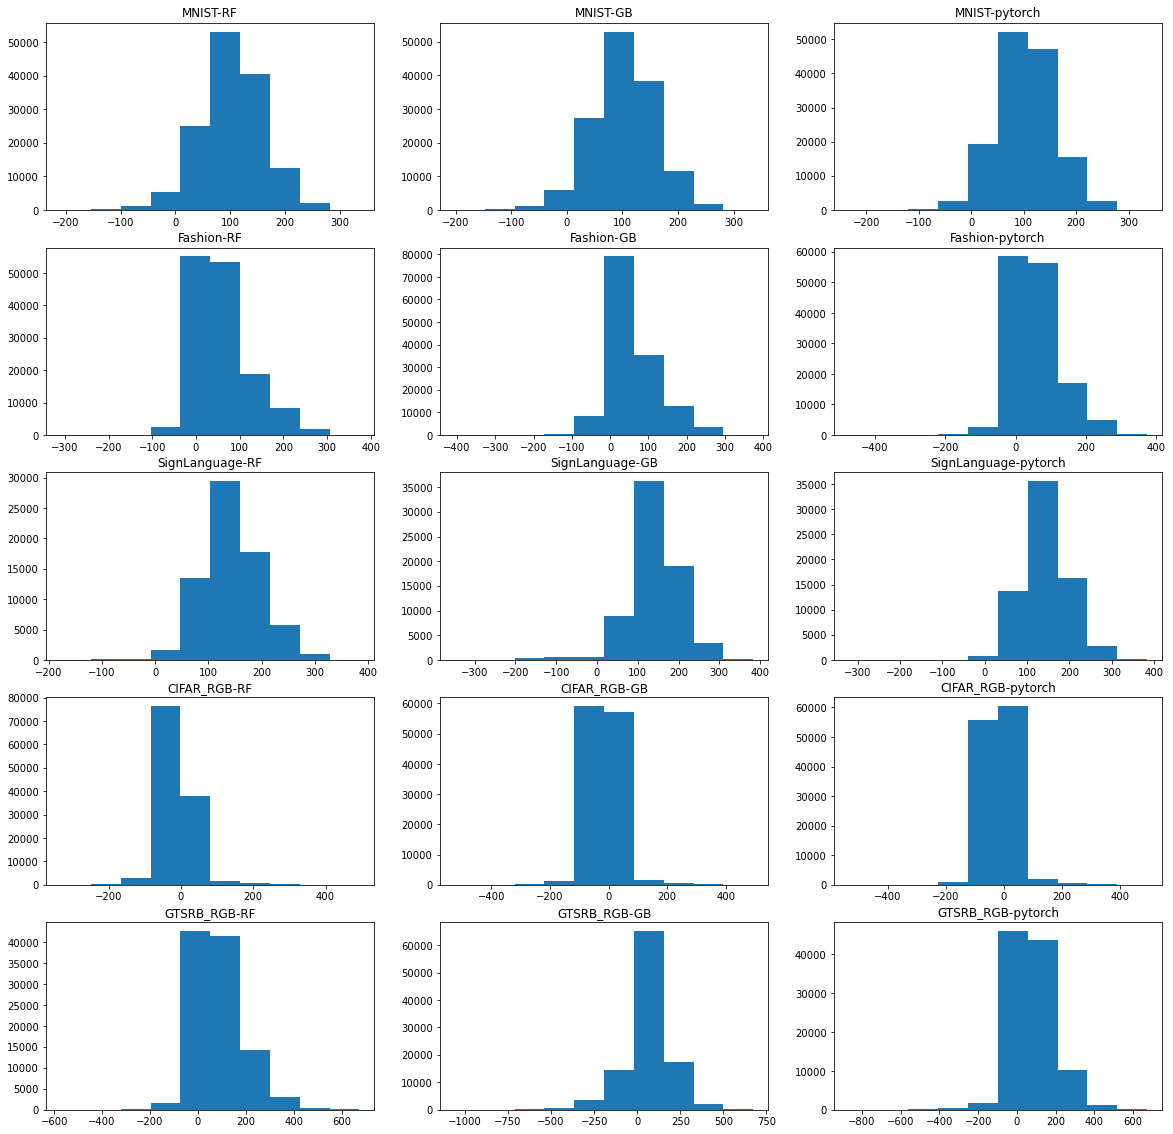

In [20]:
datasets = ['MNIST','Fashion','SignLanguage','CIFAR_RGB','GTSRB_RGB']
models = ['RF','GB','pytorch']
plt.figure(1,figsize=(20,20))

plt.title("pool=2")
i=1
for dataset_name in datasets:
    for model_name in models:
        stab=[]
        for shuffle in range(10):
            s=np.load(f'./stab/{dataset_name}/test_stab_2pool_{dataset_name}_{model_name}_{shuffle}.npy')
            stab.append(s)
        stab=np.array(stab).flatten()
        plt.subplot(5,3,i)
        plt.hist(stab)
        plt.title(f'{dataset_name}-{model_name}')
        i+=1

print("pool=2")

pool=3


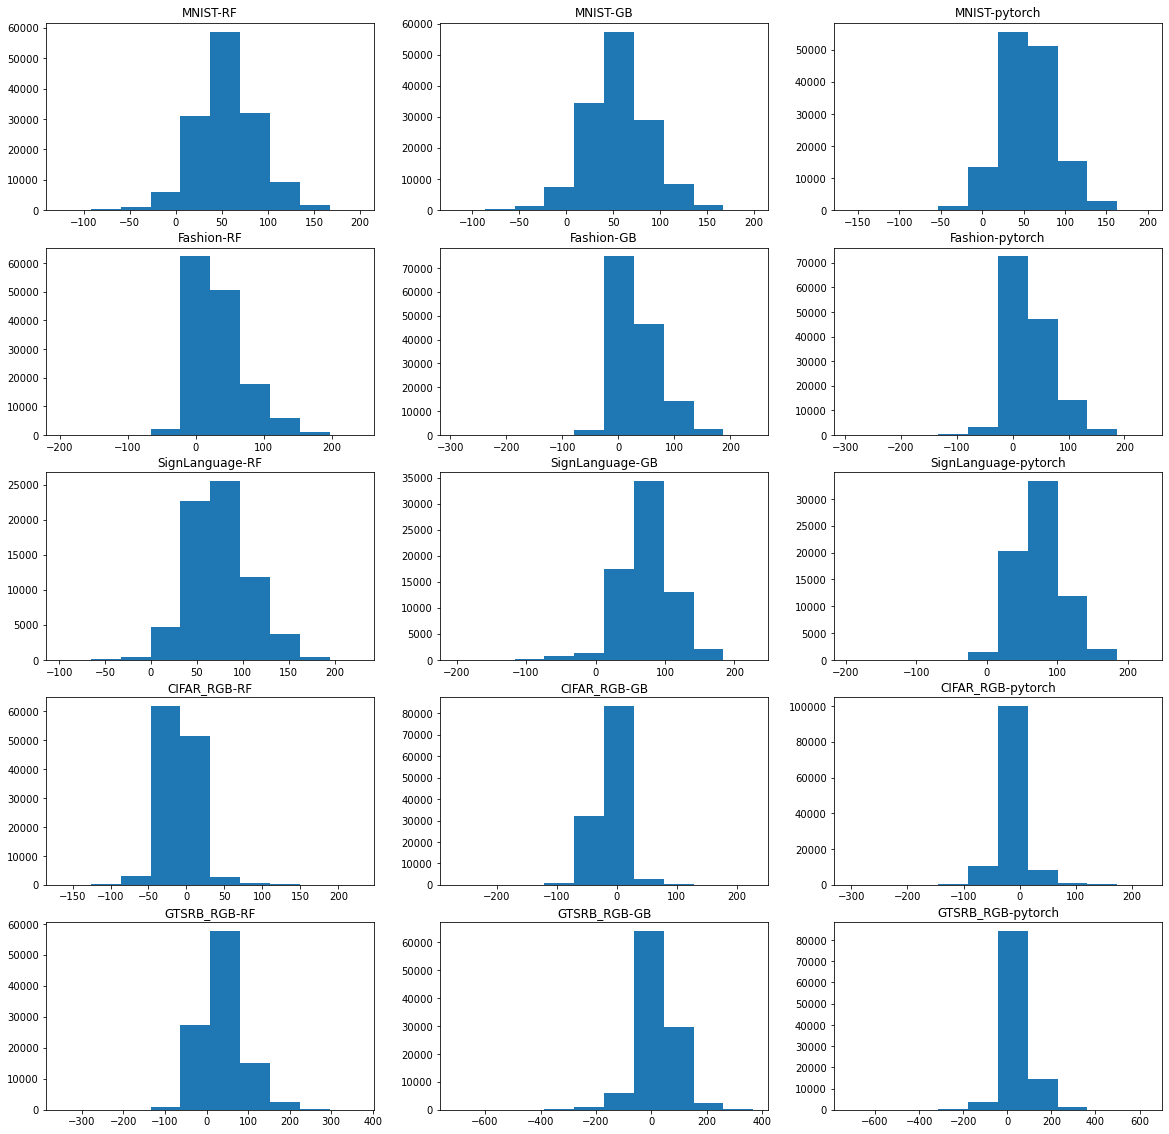

In [21]:
datasets = ['MNIST','Fashion','SignLanguage','CIFAR_RGB','GTSRB_RGB']
models = ['RF','GB','pytorch']
plt.figure(1,figsize=(20,20))

plt.title("pool=2")
i=1
for dataset_name in datasets:
    for model_name in models:
        stab=[]
        for shuffle in range(10):
            s=np.load(f'./stab/{dataset_name}/test_stab_3pool_{dataset_name}_{model_name}_{shuffle}.npy')
            stab.append(s)
        stab=np.array(stab).flatten()
        plt.subplot(5,3,i)
        plt.hist(stab)
        plt.title(f'{dataset_name}-{model_name}')
        i+=1

print("pool=3")

pool=4


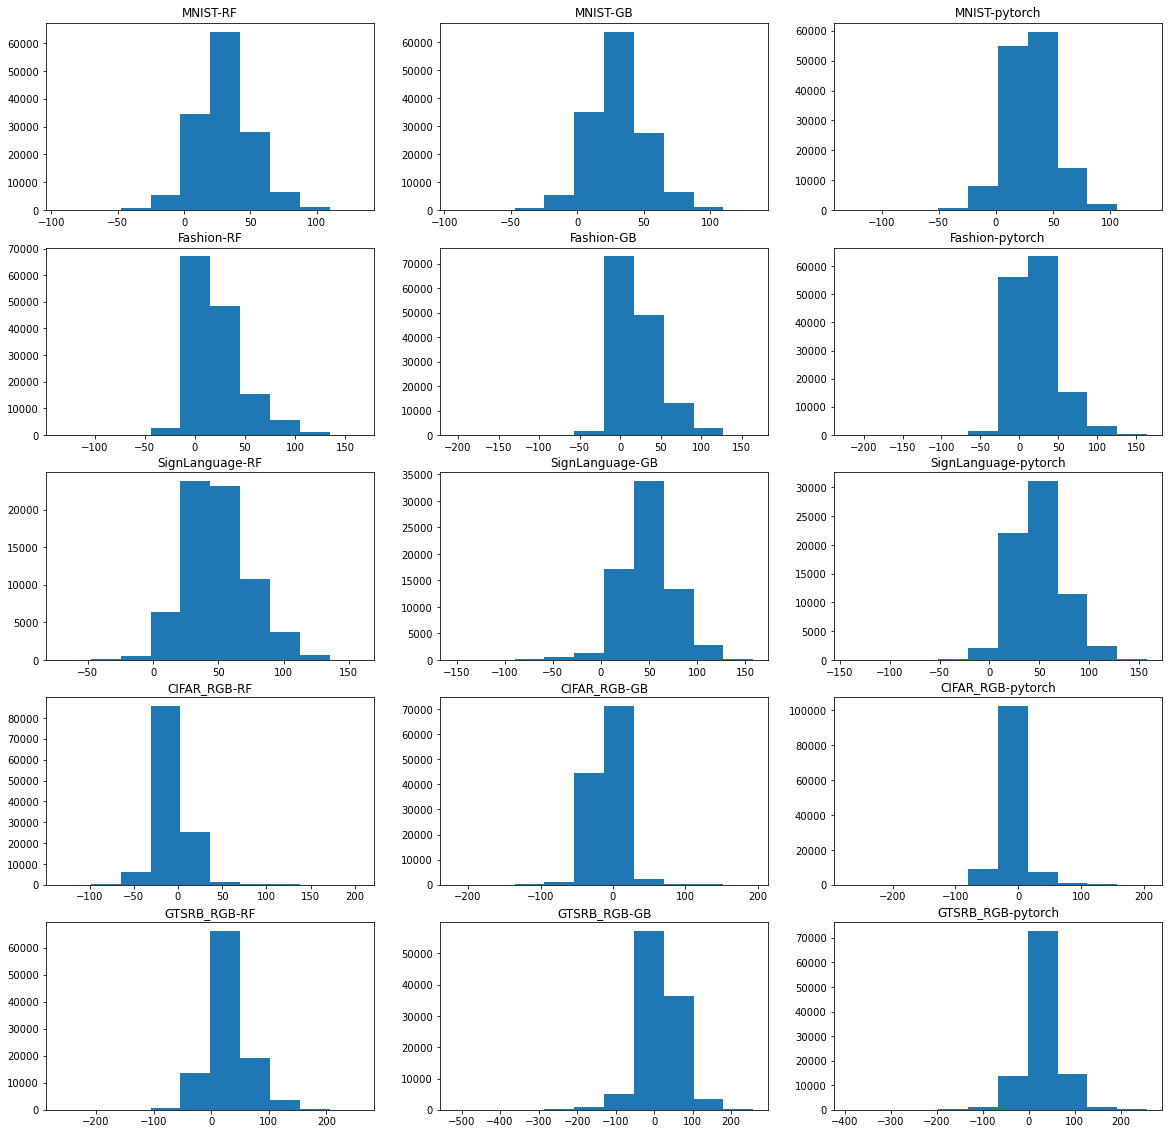

In [22]:
datasets = ['MNIST','Fashion','SignLanguage','CIFAR_RGB','GTSRB_RGB']
models = ['RF','GB','pytorch']
plt.figure(1,figsize=(20,20))

plt.title("pool=4")
i=1
for dataset_name in datasets:
    for model_name in models:
        stab=[]
        for shuffle in range(10):
            s=np.load(f'./stab/{dataset_name}/test_stab_4pool_{dataset_name}_{model_name}_{shuffle}.npy')
            stab.append(s)
        stab=np.array(stab).flatten()
        plt.subplot(5,3,i)
        plt.hist(stab)
        plt.title(f'{dataset_name}-{model_name}')
        i+=1

print("pool=4")

Distribution of the stabilities fro different pool sizes:


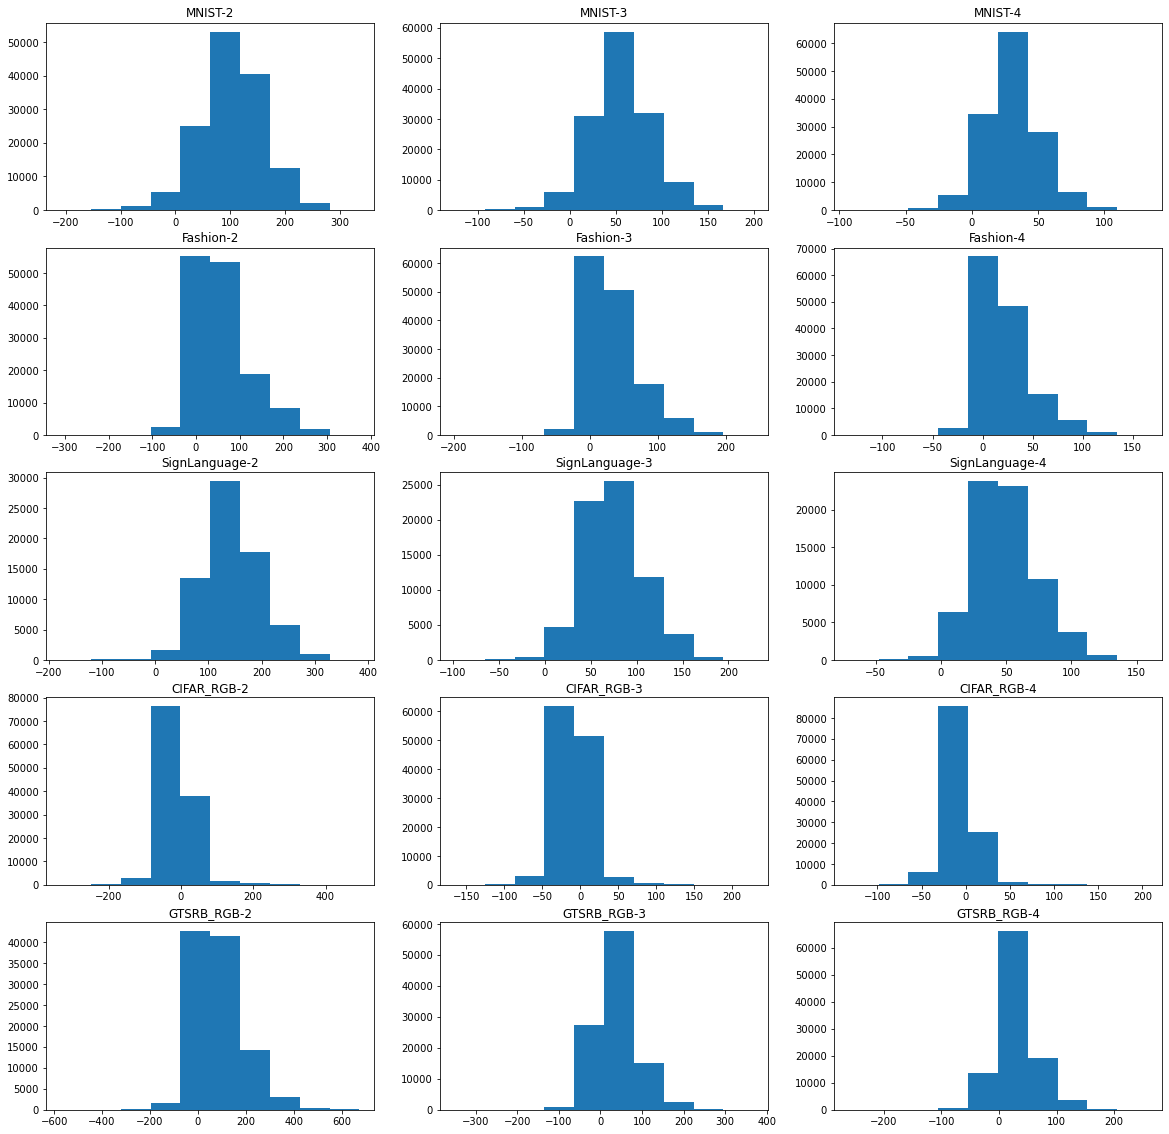

In [35]:
datasets = ['MNIST','Fashion','SignLanguage','CIFAR_RGB','GTSRB_RGB']
model_name = 'RF'
plt.figure(1,figsize=(20,20))

i=1
for dataset_name in datasets:
    for pool_size in range(2,5):
        stab=[]
        for shuffle in range(10):
            s=np.load(f'./stab/{dataset_name}/test_stab_{pool_size}pool_{dataset_name}_{model_name}_{shuffle}.npy')
            stab.append(s)
        stab=np.array(stab).flatten()
        plt.subplot(5,3,i)
        plt.hist(stab)
        plt.title(f'{dataset_name}-{pool_size}')
        i+=1

print("Distribution of the stabilities fro different pool sizes:")


In [34]:
df_time=pd.read_csv("all_time_df.csv")
df_time['MNIST']

0    {2: 82.4797901516526, 3: 187.5781990360848, 4:...
1    {2: 83.00860176278401, 3: 178.69949254099794, ...
2    {2: 81.92048388857252, 3: 178.13157531339985, ...
Name: MNIST, dtype: object

In [26]:
os.path.getsize('./MNIST/0/model/model_MNIST_GB.sav')*10^(-6)

138939357

In [31]:
os.path.getsize('./MNIST/0/model/model_MNIST_RF.sav')/10**6

117.582553

In [ ]:
x=np.array([1,2,3])
x.reshape(1,-1)

In [3]:
df=pd.read_csv("Kmeans_time_df.csv")
df

,Unnamed: 0,2,3,4
0,Fashion-RF,"(245.00526539771082, 2.083230221719947)","(444.5917651403176, 1.0480936457414913)","(741.8314292889258, 3.288634548305953)"
1,Fashion-GB,"(247.77777692209946, 0.47627420176828494)","(443.03661095607333, 1.306435209005363)","(742.1524999898078, 1.8334547484131838)"
2,Fashion-pytorch,"(247.3212661719061, 0.45677437325367287)","(443.5928707582224, 1.9172547518677152)","(746.856260320357, 2.936298009249693)"
3,MNIST-RF,"(244.86120501785527, 1.0665938802848474)","(446.738339017213, 0.5793532401374811)","(747.9178681322525, 2.598240612296618)"
4,MNIST-GB,"(247.9963077126275, 0.3968375414032784)","(444.6331656850392, 1.0377446063103763)","(746.5218527389745, 1.8332989107934374)"
5,MNIST-pytorch,"(247.3486642709438, 0.20402401267467765)","(446.7134259187642, 1.1386696072172322)","(744.9445999689345, 1.7971495320537412)"
6,SignLanguage-RF,"(421.16104958965553, 0.44604842355118074)","(856.4813252395154, 3.5130931982300555)","(1135.6236935243921, 6.380662244443616)"
7,SignLanguage-GB,"(421.7282245146815, 1.1617045761902705)","(858.085408859424, 3.552819366147818)","(1139.3867424496443, 2.6056739737787327)"
8,SignLanguage-pytorch,"(422.6494012706551, 0.8360935212373796)","(852.8096254935745, 3.8214570760956663)","(1139.5371741025922, 4.781959301160806)"


In [5]:
for i in range(1,5):
    print (i)

1
2
3
4


In [6]:
df=pd.read_csv("Full_time_df_2.csv")
df

,Unnamed: 0,PCA-1,PCA-2,PCA-3,PCA-4,randpix-1,randpix-2,randpix-3,randpix-4,randset-1,...,resize-3,resize-4,Avgpool-1,Avgpool-2,Avgpool-3,Avgpool-4,Maxpool-1,Maxpool-2,Maxpool-3,Maxpool-4
0,SignLanguage-RF,"(123.94178721912022, nan)","(394.73602543268777, nan)","(767.4848628883735, nan)","(1025.9013001689484, nan)","(130.55687433667097, nan)","(431.2917449691871, nan)","(866.0327978541281, nan)","(1123.600679782339, nan)","(131.35771274523646, nan)",...,"(260.15969540437237, nan)","(353.3255556119638, nan)","(127.5056374283653, nan)","(418.417938539737, nan)","(758.9085860993134, nan)","(1028.4552297186967, nan)","(127.56613964621928, nan)","(417.3087231591862, nan)","(769.3729991395396, nan)","(1023.2767528855509, nan)"
1,SignLanguage-GB,"(127.7915344808376, nan)","(394.2553514721764, nan)","(769.757493667067, nan)","(1026.2971210545381, nan)","(130.6587229316195, nan)","(430.7505442035127, nan)","(858.9112307145047, nan)","(1135.4958639450804, nan)","(131.50608007194046, nan)",...,"(260.57809065278684, nan)","(352.7402599772775, nan)","(127.26713907759854, nan)","(418.5441150093649, nan)","(759.7604561594037, nan)","(1032.515765869753, nan)","(127.8891655476525, nan)","(416.9988320056268, nan)","(775.0323122961604, nan)","(1018.2241080463917, nan)"
2,SignLanguage-pytorch,"(127.7808565365869, nan)","(394.9998422570505, nan)","(777.6730863308093, nan)","(1020.4537044439895, nan)","(130.8563225279674, nan)","(431.2095110111745, nan)","(858.0004790667048, nan)","(1141.286719507846, nan)","(131.61604867173546, nan)",...,"(260.7065708332758, nan)","(353.4069072923328, nan)","(127.06820599833067, nan)","(417.6266160150938, nan)","(768.2131420849564, nan)","(1033.6715634536415, nan)","(127.76596626871117, nan)","(416.86849452090877, nan)","(772.6439218371243, nan)","(1016.0635081194492, nan)"
3,Fashion-RF,"(65.08487017878362, nan)","(230.13719675774473, nan)","(478.7103937356257, nan)","(657.4170329494704, nan)","(65.83028178459762, nan)","(245.21975467532582, nan)","(505.7803673834068, nan)","(693.1395069382112, nan)","(66.12148992709874, nan)",...,"(143.13600333727743, nan)","(205.0781035609384, nan)","(64.44804832437593, nan)","(235.99999342482448, nan)","(483.63606551322715, nan)","(638.8192374309191, nan)","(64.14829461928711, nan)","(236.45600257536188, nan)","(480.0286943421949, nan)","(633.1830942619293, nan)"
4,Fashion-GB,"(64.96231195045651, nan)","(229.56354085862534, nan)","(478.3686773767396, nan)","(658.840959739495, nan)","(65.75952933709019, nan)","(245.26651781242617, nan)","(508.1973906912595, nan)","(696.3528300049347, nan)","(66.14913433279742, nan)",...,"(142.95630584150052, nan)","(204.617939133342, nan)","(64.5733571830704, nan)","(236.30365328120962, nan)","(482.3050902497145, nan)","(637.9413738996225, nan)","(64.26063474533187, nan)","(235.92646986662592, nan)","(481.6586387569232, nan)","(627.8641874949973, nan)"
5,Fashion-pytorch,"(65.0080864525842, nan)","(229.60282068025154, nan)","(478.2172503481475, nan)","(660.6562065173496, nan)","(65.64165720704867, nan)","(244.94395765498066, nan)","(509.06810894141813, nan)","(696.6146384481392, nan)","(66.27387901952513, nan)",...,"(143.24747763746956, nan)","(205.80415733029767, nan)","(64.52698086965005, nan)","(236.63519216061977, nan)","(482.50099685898317, nan)","(635.3274655745603, nan)","(64.26268031764641, nan)","(236.12709406612987, nan)","(481.16063567925926, nan)","(636.2635438918728, nan)"
6,MNIST-RF,"(65.22640244401553, nan)","(229.87912458684085, nan)","(484.14863707311133, nan)","(662.4636958052174, nan)","(65.71012023133738, nan)","(244.7904243339297, nan)","(507.7634417571022, nan)","(693.9112460660709, nan)","(66.24680971021151, nan)",...,"(142.77821919203032, nan)","(204.98610825463973, nan)","(64.47266124862611, nan)","(235.95966831946612, nan)","(482.1260272597728, nan)","(638.5440285280046, nan)","(64.49749318163308, nan)","(235.92941410026077, nan)","(481.9499570855474, nan)","(641.5147933627806, nan)"
7,MNIST-GB,"(65.25832314021922, nan)"

In [7]:
df=pd.read_csv("Full_time_df.csv")
df

,Unnamed: 0,1,2,3,4
0,MNIST-RF,"(14.504847738339228, nan)","(83.29325442150817, nan)","(188.56931574550197, nan)","(273.2407445533997, nan)"
1,MNIST-GB,"(20.48513286468952, nan)","(83.63714169457049, nan)","(188.31957785400155, nan)","(286.4621253400784, nan)"
2,MNIST-pytorch,"(22.018877021206308, nan)","(83.48628813859557, nan)","(189.08455129695804, nan)","(286.6662108928116, nan)"
3,Fashion-RF,"(22.186568761493547, nan)","(83.70878706110024, nan)","(185.54666770949842, nan)","(282.783643399206, nan)"
4,Fashion-GB,"(17.213909043464312, nan)","(83.76824512428641, nan)","(188.55599809364037, nan)","(281.60920003270337, nan)"
5,Fashion-pytorch,"(21.77179857337523, nan)","(83.64406354957654, nan)","(188.40346559733706, nan)","(282.0863610066421, nan)"
6,SignLanguage-RF,"(38.922914566382715, nan)","(159.26689656378954, nan)","(338.77396776810207, nan)","(473.52838585088244, nan)"
7,SignLanguage-GB,"(42.415085360489414, nan)","(163.38222630703183, nan)","(337.7182071256529, nan)","(473.6993880696908, nan)"
8,SignLanguage-pytorch,"(43.24296350421836, nan)","(163.506744494672, nan)","(339.90167295780753, nan)","(475.7146167826981, nan)"
9,CIFAR_RGB-RF,"(18.736862280464937, nan)","(73.09906789816327, nan)","(178.35297269660248, nan)","(258.40079929226476, nan)"
